## Volatility Targeting
    - screeners to define the universe
    - add rebalance function

In [ ]:
from finvizfinance.screener.overview import Overview
import yfinance as yf
import riskfolio as rp
import pandas as pd
import numpy as np

In [ ]:
overView = Overview()
# overView.set_filter(filters_dict= {'Index': 'S&P 500', 'Price': 'Over $50', 'Country':'USA', 'Market Cap.':'+Mid (over $2bln)', 'P/E':'Over 20', 'Beta': 'Over 1', 'Average Volume': 'Over 100K' })
overView.set_filter(signal="New High", filters_dict= {'Price': 'Over $15', 'Country':'USA', 'Market Cap.':'+Mid (over $2bln)'})
screen_data = overView.screener_view()

In [ ]:
screen_data

In [ ]:
stocks_of_interest = screen_data[screen_data['Market Cap'] >= screen_data['Market Cap'].quantile(0.60)]

In [ ]:
tickers = stocks_of_interest.Ticker.to_list() #screen_data.Ticker.to_list() #
tickers.sort()

In [ ]:
ticker_data = yf.download(tickers=tickers, start = '2019-01-01')

In [ ]:
historic_prices = ticker_data.loc[:,('Adj Close', slice(None))]
historic_prices.columns = tickers

In [ ]:
daily_returns = historic_prices[tickers].pct_change().dropna()

In [ ]:
portfolio = rp.Portfolio(returns=daily_returns)

In [151]:
# Define params for risk parity optimizer
portfolio.lowerret = 0.0008
portfolio.assets_stats(method_mu="hist", method_cov="hist", d=0.94)
w_rp = portfolio.rp_optimization(model="Classic", rm="MV", rf=0.05, hist=True)

d:\anaconda3\envs\quant-stack\lib\site-packages\riskfolio\PlotFunctions.py:569: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sizes2 = sizes2.append(item)


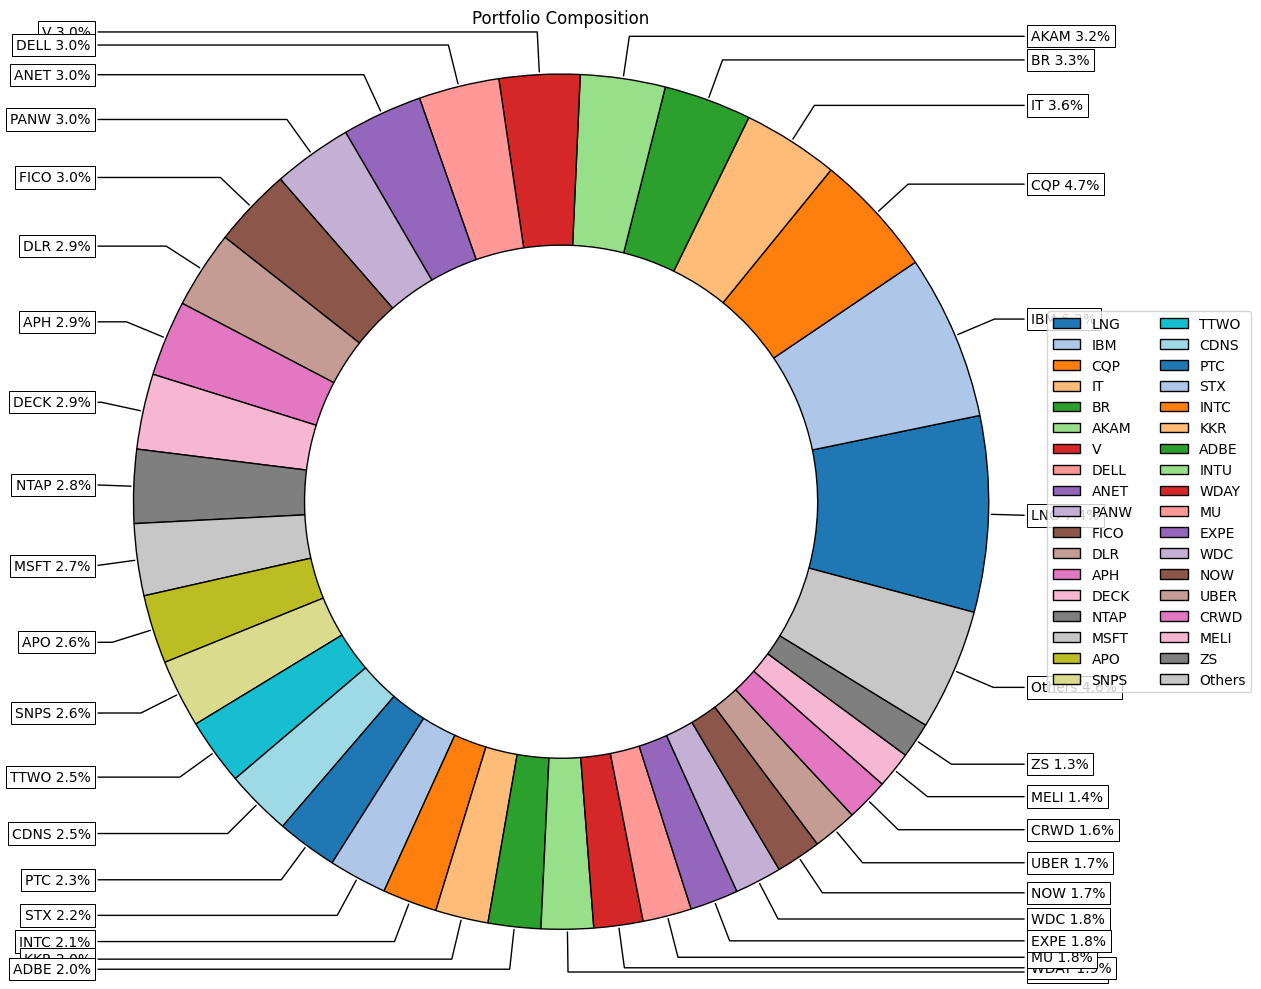

In [152]:
pie = rp.plot_pie(
    w=w_rp,
    width=12,
    height=10,
    ax=None
)

In [ ]:
ax = rp.plot_risk_con(
    w=w_rp,
    cov= portfolio.cov,
    returns= portfolio.returns,
    rm="MV",
    rf=0.05
)

In [ ]:
portfolio_value = 100_000

In [ ]:
w_rp['investment_amount'] = w_rp * portfolio_value # weight * Market Value

In [ ]:
w_rp.investment_amount.sum()

In [ ]:
w_rp['last_price'] = historic_prices.iloc[-1]

In [ ]:
w_rp['shares'] = 0 #round(w_rp.investment_amount / w_rp.last_price)

In [ ]:
#drop shares with zero values
# w_rp.loc[(w_rp[['shares']] != 0).all(axis=1)]

In [ ]:
def allocate(df, amount):
    no_more_allocated = True
    for row in df.itertuples():
        last_price = w_rp.at[row.Index, 'last_price']
        invested_amount = w_rp.at[row.Index, 'shares'] * last_price 
        if last_price < amount and w_rp.at[row.Index, 'investment_amount'] > (invested_amount+last_price):
            amount -= last_price
            w_rp.at[row.Index, 'shares'] += 1
            no_more_allocated = False
        else:
            continue
    return amount, no_more_allocated

In [ ]:
remaining = portfolio_value
stopTheLoop = False
while(True):
    if remaining > 100 and stopTheLoop == False:
        remaining, stopTheLoop = allocate(w_rp, remaining)
    else:
        break
    

In [ ]:
w_rp['invested_amount'] = w_rp.last_price * w_rp.shares

In [ ]:
w_rp

In [ ]:
w_rp[w_rp['shares'] == 0]

In [ ]:
remaining = portfolio_value - (w_rp['shares'] * w_rp['last_price']).sum()
remaining

In [ ]:
from ibapi.client import EClient
from ibapi.wrapper import EWrapper
from ibapi.contract import Contract
from ibapi.order import *

import time
import threading

In [ ]:
class IBapi(EWrapper, EClient):
    def __init__(self):
        EClient.__init__(self, self)
        self.pos_df = pd.DataFrame(columns=['Account', 'Symbol', 'SecType',
                                            'Currency', 'Position', 'Avg cost']) 
    
    def nextValidId(self, orderId: int):
        super().nextValidId(orderId)
        self.nextOrderId = orderId
    
    def position(self, account, contract, position, avgCost):
        super().position(account, contract, position, avgCost)
        
        dictionary = {"Account":account, "Symbol": contract.symbol, "SecType": contract.secType,
                        "Currency": contract.currency, "Position": position, "Avg cost": avgCost}
        if self.pos_df["Symbol"].str.contains(contract.symbol).any():
            self.pos_df.loc[self.pos_df["Symbol"]==contract.symbol,"Position"] = position
            self.pos_df.loc[self.pos_df["Symbol"]==contract.symbol,"Avg cost"] = avgCost
        else:
            self.pos_df = pd.concat([self.pos_df,pd.DataFrame(dictionary, index=[0])], ignore_index=True)

In [ ]:
def stock_contract(symbol, secType="STK", exchange="SMART", currency="USD"):
        contract = Contract()
        contract.symbol = symbol
        contract.secType = secType
        contract.exchange = exchange
        contract.currency = currency
        return contract
    
def submit_order(contract, direction, qty=100, orderType="MKT", transmit=True):
    order = Order()
    order.action = direction
    order.totalQuantity = qty
    order.orderType = orderType
    order.transmit = transmit
    order.eTradeOnly = ""
    order.firmQuoteOnly = ""
    # submit order
    app.placeOrder(app.nextOrderId, contract, order)
    app.nextOrderId += 1

In [ ]:
def run_loop():
    app.run()

app = IBapi()
app.connect('127.0.0.1', 7497, 123) # verify this on ibroker client
app.nextOrderId = None

api_thread = threading.Thread(target=run_loop, daemon=True)
api_thread.start()

counter = 1
while True:
    if isinstance(app.nextOrderId, int):
        print("Connected")
        break
    else:
        counter = counter+1
        print(f"Waiting {counter}")
        if counter == 15:
            app.disconnect()
            break
        time.sleep(1)

In [ ]:
for row in w_rp.itertuples():
    contract = stock_contract(row.Index)
    submit_order(contract, direction="BUY", qty=row.shares)

### Rebalance

In [ ]:
app.reqPositions()
time.sleep(1)
pos_df = app.pos_df

In [ ]:
df_change = (pd.merge(w_rp, pos_df.set_index('Symbol'),left_index=True,right_index=True, how="outer")
    .fillna(0)
    .assign(change = lambda x: x.shares - x.Position)
    .assign(buy = lambda x: np.where(x.change > 0, x.change, 0))
    .assign(sell = lambda x: np.where(x.change < 0, abs(x.change), 0))
)

In [ ]:
df_buy = df_change[df_change.buy > 0]
df_sell = df_change[df_change.sell > 0]

In [ ]:
for row in df_sell.itertuples():
    contract = stock_contract(row.Index)
    submit_order(contract, direction="SELL", qty=row.sell)

In [ ]:
for row in df_buy.itertuples():
    contract = stock_contract(row.Index)
    submit_order(contract, direction="BUY", qty=row.buy)

In [ ]:
app.disconnect()